# <center> DMV Review Sentiment Analysis <br> Using Tensorflow-Keras Neural Network</center>


#### <center> Chris Davis <br> October, 2021 </center>

## Table of Contents:

- ***[Importing Libraries](#Importing-Libraries)***
- ***[Preprocessing Text](#Preprocessing-Text)***
- ***[Adding GloVe embedded layer](#Adding-GloVe-embedded-layer)***
- ***[Model Building](#Model-BUilding)***
- ***[Model Fitting and Performance](#Model-Fitting-and-Performance)***
- ***[Word Clouds](#Word-Clouds)***
- ***[Citations](#Citations)***
- ***[View in Github](https://github.com/chrismdavis/DMV-Review-Sentiment-Analysis)***

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

%matplotlib inline

### Preprocessing Text

In [2]:
#Import raw data file
#df_raw = pd.read_csv('Amazon Labeled Comments.csv', sep=',')
df_raw = pd.read_csv('DMV_Reviews.csv', sep=',')

#View raw data
df_raw.head(10)

,Comment,Rating
0,Zero stars….Very rude they act like they are d...,1
1,Zero stars. Rude employees. Even with appointm...,1
2,Zero stars. Messed up our vin inspection that ...,1
3,ZERO stars. This county's attempt to automate...,1
4,Zero stars if I could. This is the WORST offic...,1
5,Zero responsibility for hazardous road repairs.,1
6,Zero organization. Have to wait in line to pic...,1
7,Zero customer service. Every time I've had to ...,1
8,Yuri ROCKS!!! After going to Lake Worth Tax of...,5
9,"You're probably thinking ""Who gives the BMV 5 ...",5


In [3]:
# Create binary sentimen from review  rating
df_raw['Sentiment'] = df_raw.Rating.apply(lambda x: 1 if x > 3 else 0)

***- Perform text standarization, stopword removal, and lemmatization:***

In [4]:
# Define regex cleaning function
def text_clean(data):
    # Convert to str
    data = str(data)
    
    # Convert to lower
    data = data.lower()

    # Remove new lines
    data = re.sub('\s+', ' ', data)

    # Convert ?!. to " "
    data = re.sub('[?!]', '.', data)

    # Remove non alpha characters
    data = re.sub('[^a-zA-Z\']', ' ', data)

    # Remove multiple spaces
    data = re.sub(' +', ' ', data)

    return data

# Define remove stopwords function
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word not in stop]
    return " ".join(filtered_words)

# Define lemmatization function
Ltzr = WordNetLemmatizer()

def word_lemmatizer(text):
    filtered_words = [Ltzr.lemmatize(word) for word in text.split()]
    return " ".join(filtered_words)

# Create copy of raw data for processing
df_clean = df_raw.copy()

# Clean/standardize text
df_clean.Comment = df_clean.Comment.apply(lambda x: text_clean(x))

# Remove stopwords
df_clean.Comment = df_clean.Comment.apply(lambda x: remove_stopwords(x))

# Lemmatize
df_clean.Comment = df_clean.Comment.apply(lambda x: word_lemmatizer(x))

***- Define test/train split and tokenize:***

In [5]:
# Split to test/train
X_train, X_test, Y_train, Y_test = train_test_split(df_clean.Comment,
                                                    df_clean.Sentiment,
                                                    random_state=42,
                                                    test_size=0.2)
# Tokenize
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

num_words = len(tokenizer.word_index) + 1
unique_words = list(tokenizer.word_index.keys())

***- Pad sequences:***

Text(0.5, 1.0, 'Comment Length')

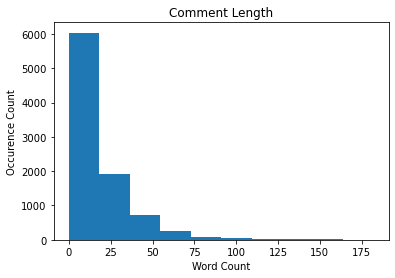

In [6]:
# View comment length histogram to set max pad length
plt.hist([len(i) for i in X_train])
plt.xlabel("Word Count")
plt.ylabel("Occurence Count")
plt.title("Comment Length")

In [7]:
# Pad Sequences
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

### Adding GloVe embedded layer

***- Creating trained GloVe embedded layer:***

In [8]:
#Create GloVe embedding layer
embeddings_index = {}

#Download glove data here: https://nlp.stanford.edu/data/glove.6B.zip
with open("Glove Data\glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### Model Building

***- Building Keras sequential model:***

In [9]:
# Create model
model = keras.models.Sequential()
model.add(layers.Embedding(num_words, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(layers.SpatialDropout1D(0.4))
model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

# Loss function
loss = keras.losses.BinaryCrossentropy(from_logits=False)

#optimizer
optim = keras.optimizers.Adam(learning_rate=0.001)

#Define metrics
metrics = ["accuracy"]

#Define early stopping metrics
early_stopping = EarlyStopping(monitor='val_accuracy', patience =5, mode = 'max')

#Compile model
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=metrics)

#Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          936800    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 979,105
Trainable params: 42,305
Non-trainable params: 936,800
_________________________________________________________________


### Model Composition:
    
***Embedded Layer:*** GloVe embedded layer

***Dropout Layer:*** Added to prevent over-fitting

***LSTM Layer:*** Stacked long short-term memory

***Dense Layer:*** Sigmoid activation binary output


### Model Parameters:

***loss function:***
Cross entropy loss function applied with out logistic fitting because the sigmoid function was already applied in the activation function.

***optimizer:***
'Adam' optimizer used (stochastic gradient descent method).

***stopping criteria:***
Stopping criteria is evaluated on the accuracy of the test set predictions as this is the metric I am trying to maximize. If there are 10 epochs of decreasing accuracy, then the model will stop fitting prematurely.

***evaluation metric:***
The model is tuned to maximize prediction accuracy

### Model Fitting and Performance

In [10]:
# Fit model to training data
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=2, callbacks=[early_stopping])

Epoch 1/50
285/285 - 12s - loss: 0.5147 - accuracy: 0.7322 - val_loss: 0.4009 - val_accuracy: 0.8090 - 12s/epoch - 41ms/step
Epoch 2/50
285/285 - 10s - loss: 0.4404 - accuracy: 0.7868 - val_loss: 0.3687 - val_accuracy: 0.8306 - 10s/epoch - 34ms/step
Epoch 3/50
285/285 - 10s - loss: 0.3979 - accuracy: 0.8126 - val_loss: 0.3408 - val_accuracy: 0.8402 - 10s/epoch - 36ms/step
Epoch 4/50
285/285 - 10s - loss: 0.3839 - accuracy: 0.8224 - val_loss: 0.3419 - val_accuracy: 0.8499 - 10s/epoch - 35ms/step
Epoch 5/50
285/285 - 10s - loss: 0.3627 - accuracy: 0.8312 - val_loss: 0.3284 - val_accuracy: 0.8538 - 10s/epoch - 34ms/step
Epoch 6/50
285/285 - 10s - loss: 0.3575 - accuracy: 0.8369 - val_loss: 0.3153 - val_accuracy: 0.8604 - 10s/epoch - 35ms/step
Epoch 7/50
285/285 - 10s - loss: 0.3430 - accuracy: 0.8429 - val_loss: 0.3469 - val_accuracy: 0.8398 - 10s/epoch - 36ms/step
Epoch 8/50
285/285 - 10s - loss: 0.3349 - accuracy: 0.8497 - val_loss: 0.3020 - val_accuracy: 0.8687 - 10s/epoch - 35ms/step


In [11]:
# Return prediction loss and accuracy
model.evaluate(X_test, Y_test)

72/72 [==============================] - 1s 11ms/step - loss: 0.3274 - accuracy: 0.8788


[0.32739853858947754, 0.8788411021232605]

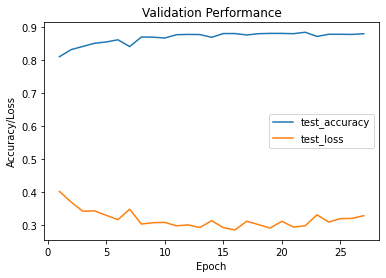

In [12]:
#Create training visualization
val_accuracy = history.history['val_accuracy']
loss = history.history['val_loss']
accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy)
plt.plot(epochs, loss)
plt.title('Validation Performance')
plt.xlabel("Epoch")
plt.ylabel('Accuracy/Loss')
plt.legend(['test_accuracy', 'test_loss'])
plt.show()

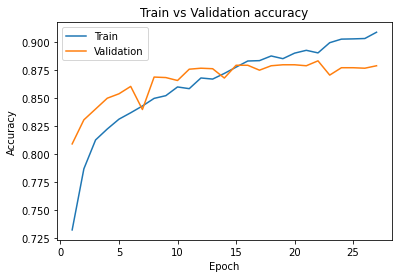

In [13]:
# Plot train accuracy vs validation accuracy
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Train vs Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

***Summary:***

- ***Model prediction accuracy:*** 88.7%
- ***Model prediction loss:*** 29.1%
- ***Total Fitting Time:*** 13 minutes

The model achieved a prediction accuracy of 88.7%. The validation accuracy curve indicates that further training would not be likely to produce substantial performance gains. Future  attempts to improve model performance should focus on the trained embedded layer as well as model construction.

### Word Clouds

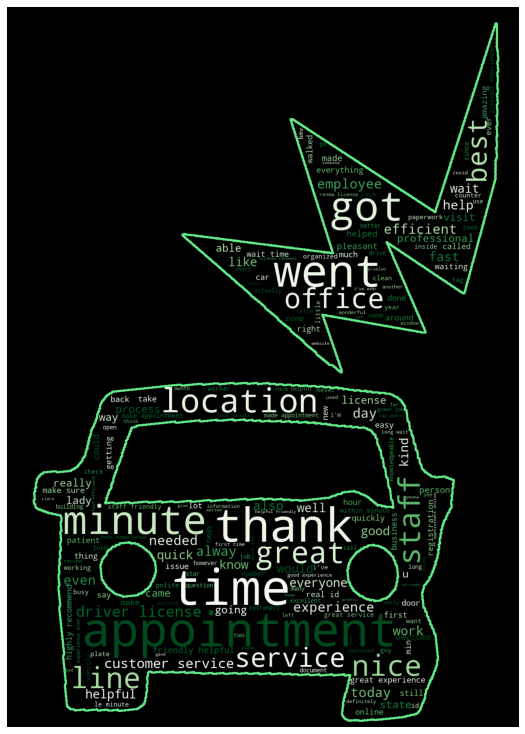

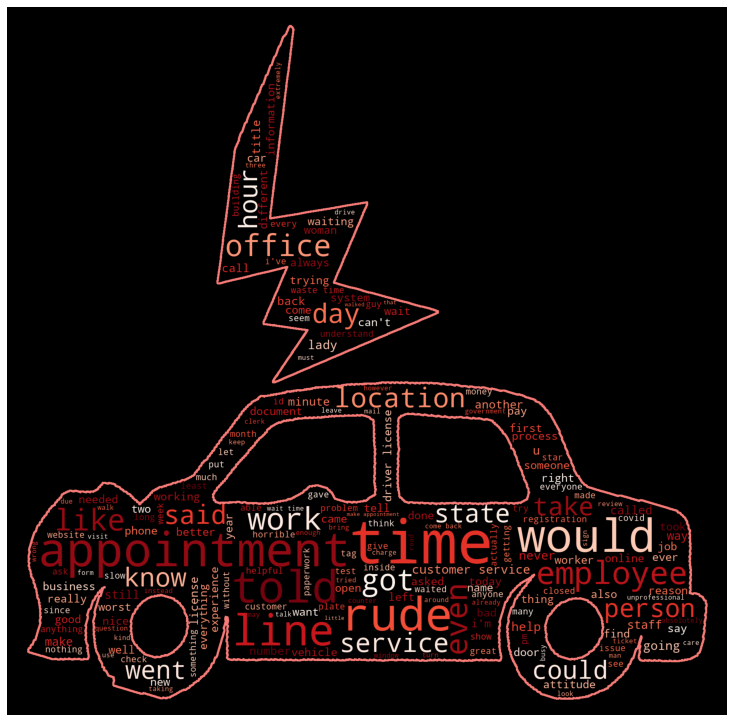

In [44]:
from wordcloud import WordCloud
from PIL import Image

mask1 = np.array(Image.open("Wordcloud/Mask11.png"))
mask2 = np.array(Image.open("Wordcloud/Mask22.png"))

pos_words = ''
neg_words = ''
stopwords = ['get','dmv','people','need','one','go','place']

for i in df_clean.Comment[df_clean.Sentiment==1]:
    pos_words+= "".join(i)+" "
    
for i in df_clean.Comment[df_clean.Sentiment==0]:
    neg_words+= "".join(i)+" "
    
pos_wordcloud = WordCloud(
                width = 655, 
                height = 800,
                background_color ='black',
                stopwords = stopwords,
                contour_width = 8,
                contour_color="#64EB8B",
                mask = mask1,
                colormap = 'Greens',
                min_font_size = 10).generate(pos_words)


neg_wordcloud = WordCloud(
                width = 655, 
                height = 800,
                background_color ='black',
                stopwords = stopwords,
                contour_width = 8,
                contour_color="#F77C78",
                mask = mask2,
                colormap = 'Reds',
                min_font_size = 10).generate(neg_words)

# plot the WordCloud image                      
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('poswords2.png')
plt.show()

# plot the WordCloud image                      
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negwords2.png')
plt.show()


### Citations

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation

Oliinyk, Halyna (2017). https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795.("Word embeddings: exploration, explanation, and exploitation (with code in Python)")